In [3]:
import pandas as pd;
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.17.0'

### Loading the data



###### Hourly electric power load values from the 33/11 KV substation in Godishala, Telangana, for 2021, including voltage, current, power factor, temperature, and humidity. The data features historical averages to fill 66 missing entries, reflecting load distribution across weekdays and weekends.

In [4]:
df = pd.read_csv("mode3_4hourly.csv")
data=df

In [5]:
data.head()

,0
0,-121.369353
1,57.394672
2,132.592606
3,-47.043739
4,-179.608418


In [6]:
type(df)

pandas.core.frame.DataFrame

### Scaling the data

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
data1 = scaler.fit_transform(data)

### Plotting the original Data

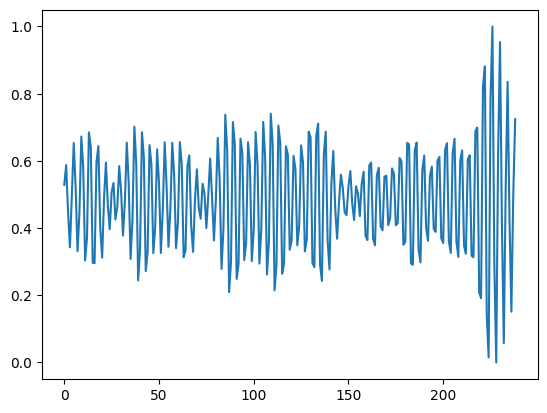

In [8]:
plt.plot(data1[1:10*24])

In [9]:
def create_input_output_pairs(data, window_length=30 * 24 , prediction_length=24, step_size=24 ):
    num_samples = (len(data) - window_length - prediction_length) // step_size + 1
    X = np.array([data[i:i + window_length] for i in range(0, num_samples * step_size, step_size)])
    y = np.array([data[i + window_length:i + window_length + prediction_length] for i in range(0, num_samples * step_size, step_size)])
    return X, y

# Create input-output pairs
X, y = create_input_output_pairs(data1)

### Diving the data into train and test

In [10]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your feature and target arrays respectively
# Scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [11]:
print(X.shape)
y.shape

(334, 720, 1)


(334, 24, 1)

In [12]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers    import Dense,Conv1D, MaxPooling1D, LSTM,Flatten, Dropout 
from keras.callbacks import EarlyStopping, ModelCheckpoint

 ### Model Architecture and Implementation
The proposed model utilises a hybrid CNN-LSTM architecture, where the convolutional layers extract spatial features from the input time series data, followed by LSTM layers that capture temporal dependencies. This design enhances the model's ability to accurately forecast electrical load over short-term intervals.

In [13]:

# Model definition with LSTM
# Build a CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(30*24, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(24))
model.compile(optimizer='adam', loss='mean_squared_error')


# Define the checkpoint to save the model during training
checkpoint_filepath = 'traingingmode3.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Set to False to save the entire model (architecture + weights)
    monitor='loss',           # Monitors the training loss
    mode='min',               # Save the model with the lowest loss
    save_best_only=True)       # Only save the model if the loss improves

# Train the model and save the best version
model.fit(X, y, epochs=620, batch_size=32, callbacks=[model_checkpoint_callback])

# Save the final trained model (optional if you want to save after training)
model.save('training_mode3.keras')

C:\Users\Ramte\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 326ms/step - loss: 0.1750
Epoch 2/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step - loss: 0.0151
Epoch 3/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step - loss: 0.0086
Epoch 4/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step - loss: 0.0051
Epoch 5/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - loss: 0.0058
Epoch 6/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.0051
Epoch 7/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 383ms/step - loss: 0.0053
Epoch 8/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - loss: 0.0047
Epoch 9/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 392ms/step - loss: 0.0047
Epoch 10/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - loss: 0.0047
Epoch 11/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 389ms/step - loss: 0.0047
Epoch 12/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 393ms/step - loss: 0.0042
Epoch 13/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - loss: 0.0051
Epoch 14/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 381ms/step - loss: 0.0044
Epoch 15/620
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [14]:
model.evaluate(X_test,y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 9.1178e-04


0.0008951484924182296

In [15]:
y_pred=model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


In [16]:
y_pred1=model.predict(X_train)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [17]:
y_train = np.squeeze(y_train)  # Remove the extra dimension
y_test = np.squeeze(y_test)    # Remove the extra dimension

In [18]:

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_train = mean_absolute_percentage_error(y_train, y_pred1)
mape_test = mean_absolute_percentage_error(y_test, y_pred)

# Print MAPE
print("Training Set MAPE:", mape_train, "%")
print("Test Set MAPE:", mape_test, "%")

Training Set MAPE: 4.492686940421821 %
Test Set MAPE: 4.554072349189826 %


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae_train = mean_absolute_error(y_train, y_pred1)
mae_test = mean_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred1))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R-squared
r2_train = r2_score(y_train, y_pred1)
r2_test = r2_score(y_test, y_pred)

# Print all metrics
print("Training Set MAE:", mae_train)
print("Test Set MAE:", mae_test)
print("Training Set RMSE:", rmse_train)
print("Test Set RMSE:", rmse_test)
print("Training Set R²:", r2_train)
print("Test Set R²:", r2_test)

Training Set MAE: 0.020802054811656503
Test Set MAE: 0.021152357371972342
Training Set RMSE: 0.02847588622979602
Test Set RMSE: 0.029919031509169525
Training Set R²: 0.8425782423215074
Test Set R²: 0.7511184165370389


### Performance on Training data

C:\Users\Ramte\AppData\Local\Temp\ipykernel_20864\1372667498.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right')


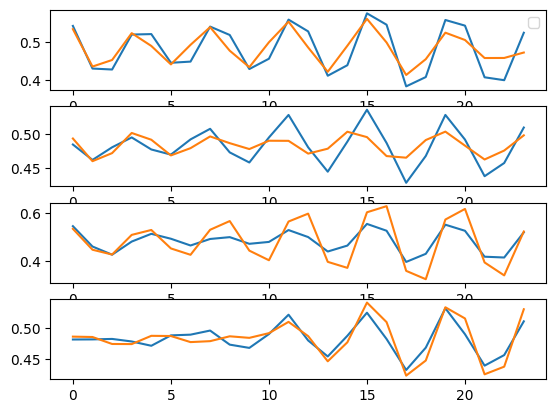

In [20]:
fig, axs = plt.subplots(4,1) 

axs[0].plot(y_pred1[7])
axs[0].plot(y_train[7])
axs[0].legend(loc='upper right')
# Add labels and title

axs[1].plot(y_pred1[10])
axs[1].plot(y_train[10])

axs[2].plot(y_pred1[15])
axs[2].plot(y_train[15])

axs[3].plot(y_pred1[30])
axs[3].plot(y_train[30])

### Performance on test Data

C:\Users\Ramte\AppData\Local\Temp\ipykernel_20864\3820575154.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right')


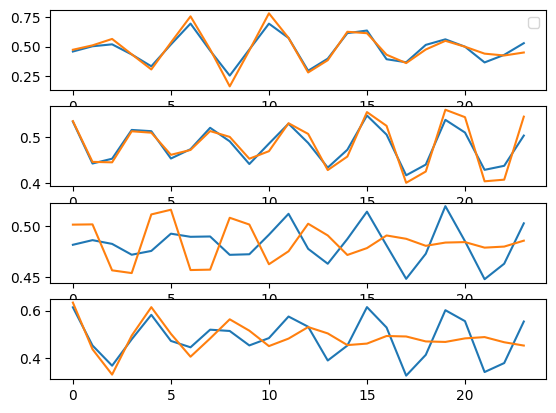

In [21]:
fig, axs = plt.subplots(4,1) 

axs[0].plot(y_pred[7])
axs[0].plot(y_test[7])
axs[0].legend(loc='upper right')
# Add labels and title

axs[1].plot(y_pred[10])
axs[1].plot(y_test[10])

axs[2].plot(y_pred[15])
axs[2].plot(y_test[15])

axs[3].plot(y_pred[30])
axs[3].plot(y_test[30])